In [30]:
import tensorflow as tf
print(tf.__version__)

2.4.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [1]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset["DESCR"])


.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

In [2]:
# Save the input and target variables
print(diabetes_dataset.keys())

data = diabetes_dataset["data"]
targets = diabetes_dataset["target"]

dict_keys(['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])


In [3]:
# Normalise the target data (this will make clearer training curves)
targets = (targets - targets.mean(axis=0)) / targets.std()

targets


array([-1.47194752e-02, -1.00165882e+00, -1.44579915e-01,  6.99512942e-01,
       -2.22496178e-01, -7.15965848e-01, -1.83538046e-01, -1.15749134e+00,
       -5.47147277e-01,  2.05006151e+00, -6.64021672e-01, -1.07957508e+00,
        3.48889755e-01,  4.26806019e-01, -4.43258925e-01,  2.45001404e-01,
        1.80071184e-01, -1.05621783e-01, -7.15965848e-01,  2.06043272e-01,
       -1.09256112e+00, -1.33929596e+00, -1.09256112e+00,  1.20596866e+00,
        4.13819975e-01,  6.47568766e-01, -1.96524090e-01, -8.71798376e-01,
       -2.74440354e-01,  1.69943833e+00, -3.00412442e-01, -1.20943552e+00,
        2.45262887e+00, -8.45826288e-01, -1.13151925e+00, -6.51035629e-01,
        1.46568953e+00,  1.60853602e+00,  1.29687096e+00, -8.06868156e-01,
       -6.77007716e-01, -1.26137969e+00, -1.18346343e+00, -7.80896068e-01,
        1.38777327e+00, -1.28735178e+00,  4.91736239e-01, -1.31593871e-01,
       -1.00165882e+00, -1.31593871e-01,  3.72247006e-02,  9.46247777e-01,
       -1.20943552e+00, -

In [4]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)

print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [5]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
  model = Sequential([
      Dense(128, activation="relu", input_shape=(train_data.shape[1], )),
      Dense(128, activation="relu"),
      Dense(128, activation="relu"),
      Dense(128, activation="relu"),
      Dense(128, activation="relu"),
      Dense(128, activation="relu"),
      Dense(1)                   
  ]
  )
  return model

model = get_model()

In [6]:
# Print the model summary

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [7]:
# Compile the model
model.compile(optimizer="adam", loss='mse', metrics=['mae'])


In [8]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)


In [9]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets, verbose=2)
print(history.history.keys())

2/2 - 0s - loss: 0.8649 - mae: 0.6646
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


#### Plot the learning curves

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

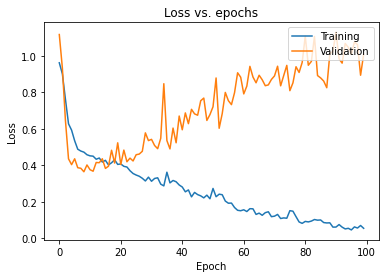

In [11]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [12]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [13]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, activation="relu", input_shape=(train_data.shape[1],)),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(1)
    ])
    return model

In [14]:
# Re-build the model with weight decay and dropout layers
def get_regularised_model(wd, rate):
  model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate), 
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)                  
  ]
  )
  return model

In [15]:
# Compile the model
model = get_regularised_model(1e-04, 0.3)


In [16]:
# Train the model, with some of the data reserved for validation
model.compile(optimizer="adam", loss='mse', metrics=['mae'])


In [17]:
# Evaluate the model on the test set
history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)


In [18]:
model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.6938 - mae: 0.5926


[0.6938300132751465, 0.5926343202590942]

#### Plot the learning curves

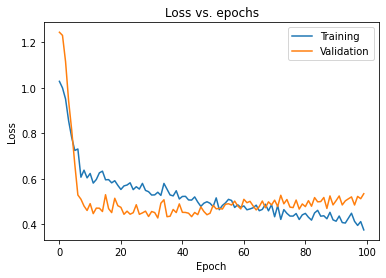

In [19]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [20]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):

  def on_train_begin(self, logs=None):
    print("Starting training...")

  def on_epoch_begin(self, epoch, logs=None):
    print(f"Starting epoch {epoch}")

  def on_train_batch_begin(self, batch, logs=None):
    print(f"Training: Starting batch {batch}")

  def on_train_batch_end(self, batch, logs=None):
    print(f"Training: Finished batch {batch}")

  def on_epoch_end(self, epoch, logs=None):
    print("Finished epoch {epoch}")

  def on_train_end(self, logs=None):
    print("Finished training!")

class TestingCallback(Callback):

  def on_test_begin(self, logs=None):
    print("Starting testing...")

  def on_test_batch_begin(self, batch, logs=None):
    print(f"Testing: Starting batch {batch}")

  def on_test_batch_end(self, batch, logs=None):
    print(f"Testing: Finished batch {batch}")

  def on_test_end(self, logs=None):
    print("Finished testing!")

class PredictionCallback(Callback):

  def on_predict_begin(self, logs=None):
    print("Starting prediction...")

  def on_predict_batch_begin(self, batch, logs=None):
    print(f"Predicting: Starting batch {batch}")

  def on_predict_batch_end(self, batch, logs=None):
    print(f"Predicting: Finished batch {batch}")

  def on_predict_end(self, logs=None):
    print("Finished predicting!")

In [21]:
# Re-build the model
model = get_regularised_model(1e-05, 0.3)


In [22]:
# Compile the model
model.compile(optimizer="adam", loss='mse')


#### Train the model with the callback

In [23]:
# Train the model, with some of the data reserved for validation
model.fit(train_data, train_targets, epochs=3, batch_size=128, verbose=False, callbacks=[TrainingCallback()])


Starting training...
Starting epoch 0
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch {epoch}
Starting epoch 1
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch {epoch}
Starting epoch 2
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch {epoch}
Finished training!


In [24]:
# Evaluate the model
model.evaluate(test_data, test_targets, verbose=False, callbacks=[TestingCallback()])


Starting testing...
Testing: Starting batch 0
Testing: Finished batch 0
Testing: Starting batch 1
Testing: Finished batch 1
Finished testing!


0.9494902491569519

In [25]:
# Make predictions with the model
model.predict(test_data, verbose=False, callbacks=[PredictionCallback()])


Starting prediction...
Predicting: Starting batch 0
Predicting: Finished batch 0
Predicting: Starting batch 1
Predicting: Finished batch 1
Finished predicting!


array([[-0.02596708],
       [-0.07580823],
       [ 0.01930572],
       [-0.11128053],
       [-0.09554613],
       [ 0.04500918],
       [ 0.06244978],
       [-0.03713526],
       [-0.02161418],
       [-0.0696344 ],
       [ 0.05263235],
       [ 0.07199323],
       [-0.09094047],
       [ 0.02789608],
       [-0.1152328 ],
       [-0.03851807],
       [-0.08882945],
       [-0.0380818 ],
       [ 0.07620806],
       [ 0.07564145],
       [ 0.03805942],
       [-0.09159112],
       [-0.13102664],
       [-0.1019815 ],
       [-0.10568681],
       [-0.1085215 ],
       [-0.08057123],
       [-0.07715864],
       [ 0.05189643],
       [ 0.02686895],
       [-0.02064268],
       [-0.09634652],
       [-0.08763368],
       [-0.08548553],
       [ 0.01003407],
       [-0.03354676],
       [-0.01800442],
       [-0.01980318],
       [ 0.05838232],
       [ 0.08223896],
       [-0.1101596 ],
       [ 0.09628888],
       [ 0.00567957],
       [ 0.01490415],
       [ 0.03979673]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [41]:
# Re-train the unregularised model
unregularized_model = get_model()
unregularized_model.compile(optimizer="adam", loss="mse")
unreg_history = unregularized_model.fit(train_data, train_targets, epochs=100, 
                                        validation_split=0.15, batch_size=64, verbose=False, 
                                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])


In [42]:
# Evaluate the model on the test set
unregularized_model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.5667


0.5666643381118774

In [43]:
# Re-train the regularised model
regularized_model = get_regularised_model(1e-08, 0.2)
regularized_model.compile(optimizer="adam", loss="mse")
reg_history = regularized_model.fit(train_data, train_targets, epochs=100,
                                    validation_split=0.15, batch_size=64, verbose=False,
                                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])


In [44]:
# Evaluate the model on the test set
regularized_model.evaluate(test_data, test_targets, verbose=2)


2/2 - 0s - loss: 0.7709


0.7709280848503113

#### Plot the learning curves

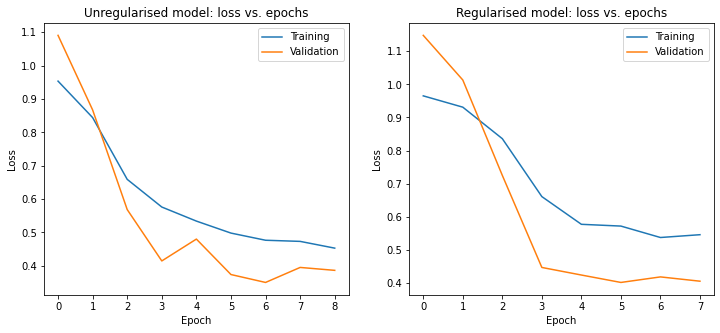

In [45]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()